# DSI37 Capstone Project: Classifying Skin Diseases Using Computer Vision

<a id='part_i'></a>
[Part II](Part2-EfficientnetModel.ipynb#part_ii) <br>
[Part III](Part3-VggModel.ipynb#part_iii) <br>
[Part IV](Part4-ResnetModel.ipynb#part_iv) <br>
[Part V](Part5-Ensemble_Insights_Recommendations.ipynb#part_v)

<a id='part_i'></a>
# Part 1: Introduction & Exploratory Data Analysis

## Contents

[1. Introduction](#intro) <br>
[2. Dataset](#data) <br>
[3. Exploratory Data Analysis](#eda) <br>

<a id='intro'></a>
## 1. Introduction

### Problem Description
In Singapore, minor skin ailments are prevalent. One example would be eczema, which affects up to 20% of children and 10% of adults<sup>1</sup>. The top 4 skin diseases in Singapore are eczema, acne, viral and fungal skin infections<sup>2</sup>. Mild cases of all these conditions are self-treatable, but the general knowledge among the layman population regarding these conditions is often limited. As a result, individuals frequently seek diagnosis and treatment at clinics, contributing to long waiting times and the necessity of taking medical leave from work. These factors contribute to increased healthcare burden and reduced productivity on both individual and societal levels.

<sup>1. https://www.a-star.edu.sg/News/astarNews/news/features/atopic-dermatitis-the-search-for-answers</sup>

<sup>2. https://pubmed.ncbi.nlm.nih.gov/35535625/</sup>

### Problem Statement

The aim of this project is to develop an image classification model using computer vision techniques to accurately classify common skin diseases prevalent in Singapore, specifically acne, warts, eczema, psoriasis, and fungal skin infections. The model should assist individuals in obtaining a preliminary diagnosis of their skin conditions.

In addition to the image classification component, another goal is to deploy the model on a user-friendly platform that goes beyond disease classification. The platform will provide individuals with pertinent information regarding their diagnosed skin condition, including the disease course, prognosis, and available treatment options. It will also offer details about the availability, proper usage, potential side effects, and other relevant information about recommended medications for self-treatment.

By incorporating comprehensive information into the application/website, individuals will have access to a reliable and accessible resource that not only aids in diagnosing their skin conditions but also offers valuable insights into their specific disease, potential treatment paths, and medication-related details. This should allow them to explore self-treatment options with over-the-counter products and potentially reduce the need for clinic visits and associated waiting times. This comprehensive approach has the potential to not only alleviate the strain on clinics and reduce waiting times but also empower individuals to make informed decisions about their skin health, enhancing productivity at both the individual and societal levels.

### Objectives
- Develop an image classification model using convolutional neural networks (CNNs) to accurately classify five skin diseases (acne, eczema, fungal skin infections, psoriasis and warts).
- Creating an user-friendly interface or application that allows individuals to upload images of their skin conditions. The application will provide a preliminary diagnosis along with helpful information and suggestions.

<a id='data'></a>
## 2. Dataset

**1. Kaggle (https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset)**
- `Eczema (1677 images)`
- `Warts Molluscum and other Viral Infections (2103 images)`
- `Psoriasis pictures Lichen Planus and related diseases (2055 images)`
- `Tinea Ringworm Candidiasis and other Fungal Infections (1702 images)`

After downloading the raw folders, I removed microscopic images and extracted only the files with labels in the file name (e.g. 'eczema', 'warts', 'psoriasis', 'tinea'). Below are the results after filtering:

- `Eczema (875 images)`
- `Warts (504 images)`
- `Fungal Skin Infections (911 images)`
- `Psoriasis (664 images)`

**2. Dermnetnz.org (https://dermnetnz.org/image-library)**
- `311 acne images were scraped from 5 categories`

Categories include:
- Acne affecting the back images
- Acne affecting the face images
- Facial acne images
- Infantile acne images
- Steroid acne images

<a id='eda'></a>
## 3. Exploratory Data Analysis

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from PIL import Image
import dask.bag as bag
from dask.diagnostics import ProgressBar

In [ ]:
# Setting directories
cwd = '/content/drive/MyDrive/Colab Notebooks/Capstone 3'
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/data'

### Identifying unique classes and class imbalance

In [ ]:
# Creating a dataframe for images class and counts
quantity = {}
for category in os.listdir(data_dir):
  quantity[category] = len(os.listdir(os.path.join(data_dir, category)))
quantity_df = pd.DataFrame(list(quantity.items()), index=range(0,len(quantity)), columns=['class', 'count'])
display(quantity_df)
print("Number of images in the dataset : ", sum(quantity.values()))

,class,count
0,psoriasis,664
1,warts,504
2,eczema,875
3,fungal,911
4,acne,311


Number of images in the dataset :  3265


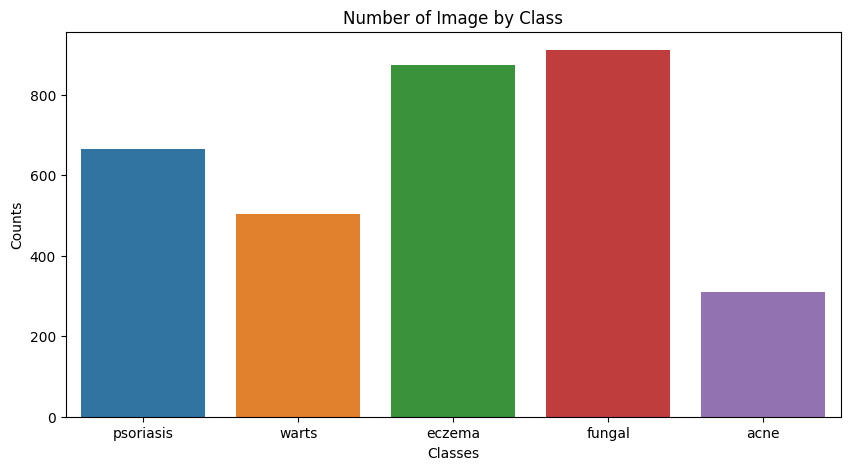

In [ ]:
# Visualizing images class and counts using a barplot
plt.figure(figsize=(10,5))
sns.barplot(x='class',y='count',data=quantity_df)
plt.title('Number of Image by Class')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

Takeaway:
- Distribution is quite balanced, with the exception of acne which has the lowest number of images (311), ~66% less than fungal images (911).
- This may cause the model to overtrain on other categories.
- If this becomes an issue, I might consider to upsample this category.

### Viewing image examples

In [ ]:
# List of classes
classes = ['warts', 'psoriasis', 'fungal', 'eczema', 'acne']

# Class directories
class_dict = {}
for cat in classes:
  class_dict[cat] = os.path.join(data_dir, cat)

In [ ]:
# Defining a function to show examples of images in the train directory
def show_few_images(number_of_examples=2):
    figure1, ax1 = plt.subplots(number_of_examples, len(classes), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for category in os.listdir(data_dir):
        image_ids = os.listdir(os.path.join(data_dir, category))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            image = plt.imread(os.path.join(data_dir, category, image_ids[j]))
            ax1[axs].imshow(image)
            ax1[axs].set_title(category)
            axs += 1

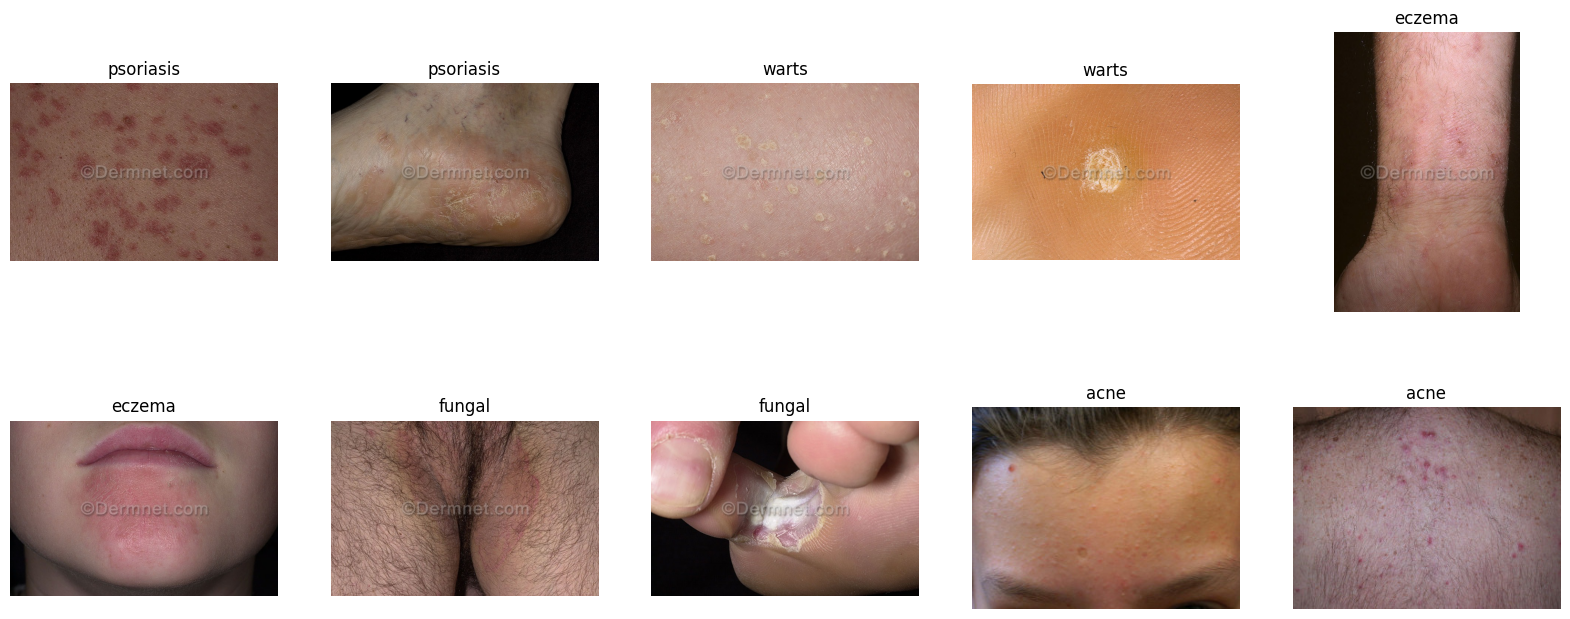

In [ ]:
# Showing examples of images
show_few_images(2)

### Plotting image sizes

In [ ]:
 # Creating a function that returns the dimensions for an image
def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

[########################################] | 100% Completed | 4.51 s
[########################################] | 100% Completed | 8.32 s
[########################################] | 100% Completed | 7.46 s
[########################################] | 100% Completed | 8.33 s
[########################################] | 100% Completed | 2.01 s


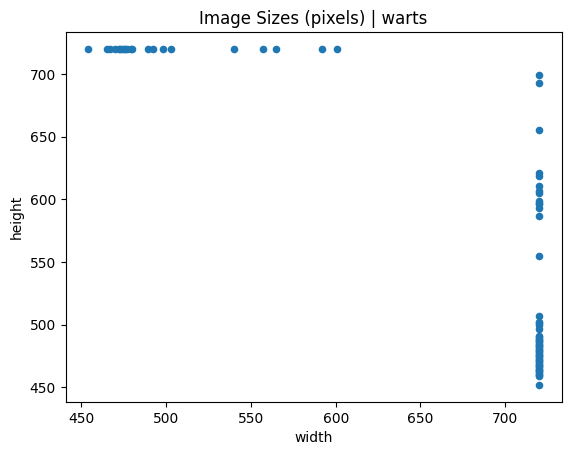

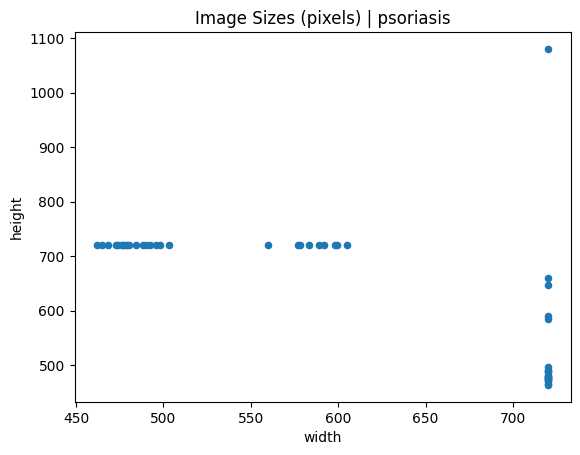

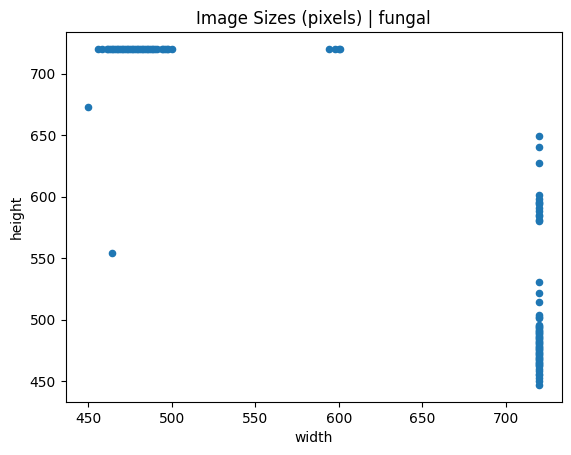

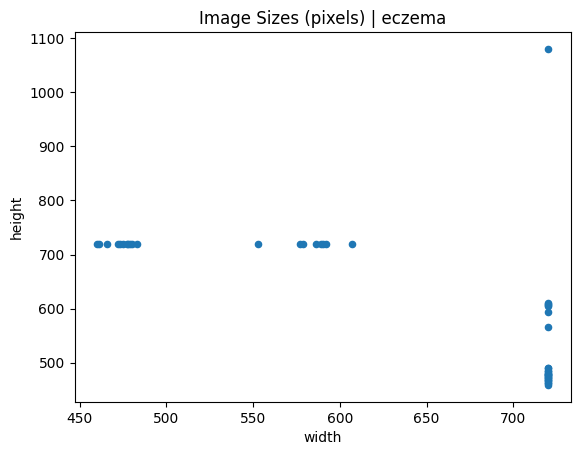

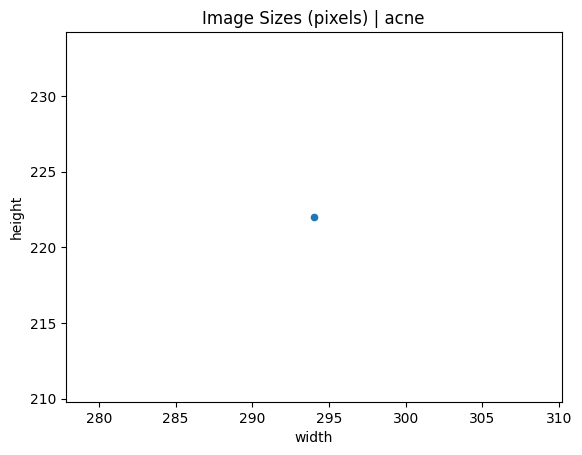

In [ ]:
# Plotting scatterplot of image pixels (height vs width)
for cat, directory in class_dict.items():
  filelist = [os.path.join(directory, file) for file in os.listdir(directory)]
  dims = bag.from_sequence(filelist).map(get_dims)
  with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(cat))

### Plotting channel intensities

In [ ]:
# Create function that calculates the average channel intensity
def calculate_channel_average(img, channel):
    """
    Calculate channel average.
    Remark: Only used for plotting
    """
    channel_dict = {"R": 0, "G": 1, "B": 2}
    channel_idx = channel_dict[channel]
    channel_intensities = np.array([row[:, channel_idx] for row in img]).flatten()
    return np.mean(channel_intensities)

In [ ]:
# Creating a dataframe containing labels and average channel intensities
red_channel_average = {}
green_channel_average = {}
blue_channel_average = {}

channels = [red_channel_average, green_channel_average, blue_channel_average]
channels_colour = ['R', 'G', 'B']
for channel, channel_colour in zip(channels, channels_colour):
  for cat, directory in class_dict.items():
    filelist = [os.path.join(directory, file) for file in os.listdir(directory)]
    imglist = [np.asarray(Image.open(img_dir)) for img_dir in filelist]
    channel_averages = [calculate_channel_average(np.array(img), channel_colour) for img in imglist]
    channel[cat] = np.mean(channel_averages)

channel_intensities = pd.DataFrame({"Label": red_channel_average.keys(),
                                    "Red": red_channel_average.values(),
                                    "Green": green_channel_average.values(),
                                    "Blue": blue_channel_average.values()
})

channel_intensities

,Label,Red,Green,Blue
0,warts,151.600381,109.490630,98.245370
1,psoriasis,130.839522,96.434123,86.450755
2,fungal,135.639669,101.417859,95.900386
3,eczema,132.608037,96.477442,85.521331
4,acne,156.682882,112.971806,101.428996


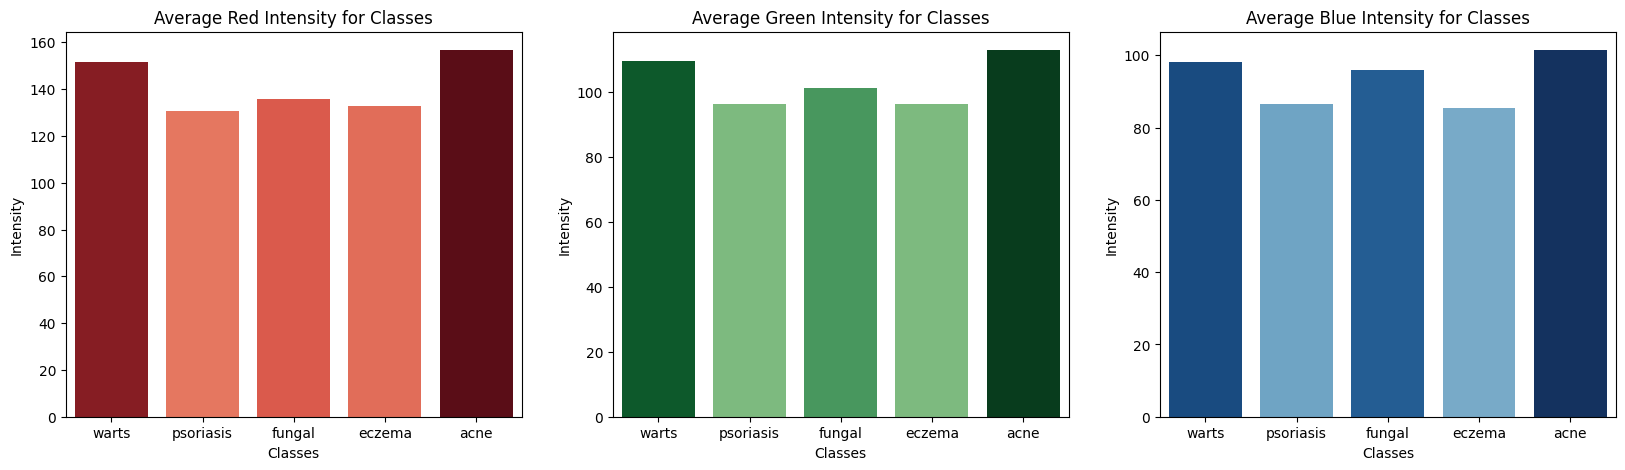

In [ ]:
# Setting subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Define custom colormap intensities for each channel
red_intensities = channel_intensities['Red'].values
green_intensities = channel_intensities['Green'].values
blue_intensities = channel_intensities['Blue'].values

# Loop through each channel and create the bar plot
for i, channel in enumerate(['Red', 'Green', 'Blue']):
    ax = axes[i]

    # Get the intensities for the current channel
    if channel == 'Red':
        intensities = red_intensities
        cmap = plt.colormaps.get_cmap('Reds')  # Use 'Reds' colormap for red channel
    elif channel == 'Green':
        intensities = green_intensities
        cmap = plt.colormaps.get_cmap('Greens')  # Use 'Greens' colormap for green channel
    else:
        intensities = blue_intensities
        cmap = plt.colormaps.get_cmap('Blues')  # Use 'Blues' colormap for blue channel

    # Normalize the intensities to range [0, 1]
    norm = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))

    # Rescale the normalized values to the custom range [0.5, 1] so the colours are darker
    norm = 0.5 + norm * 0.5

    # Map colors based on normalized intensities
    colors = cmap(norm)

    # Create the bar plot with the colors
    sns.barplot(data=channel_intensities, y=channel, x='Label', ax=ax, palette=colors)
    ax.set_ylabel('Intensity')
    ax.set_xlabel('Classes')
    ax.set_title('Average {} Intensity for Classes'.format(channel))

plt.show()

Takeaways:
1. Acne followed by warts has the highest colour intensities for all channels.
2. Red channel has the highest intensities. This is expected.
3. Fungal has slightly higher blue intensity compared to psoriasis and eczema.

# Understanding distribution of images

In [ ]:
# class_dict is a dictionary of categories (key) to their respective directories (value)
# Creating a dataframe filedict which contains filenames and their corresponding labels
filedict = {}
for cat, directory in class_dict.items():
  filedict[cat] = [file for file in os.listdir(directory)]

# Initializing empty dataframe image_df
image_df = pd.DataFrame()

# Iterate through filedict to form a dataframe
for key, value in filedict.items():
    temp_df = pd.DataFrame({'filename': value, 'label': key})
    image_df = pd.concat([image_df, temp_df], ignore_index=True)

display(image_df)

,filename,label
0,t-10WartsTransplantPt10061.jpg,warts
1,t-12WartPeriungual.jpg,warts
2,t-12WartNitrogen4.jpg,warts
3,t-12WartNitrogen1.jpg,warts
4,t-12WartAldara.jpg,warts
...,...,...
3260,steroid-acne-08.jpg,acne
3261,steroid-acne-06.jpg,acne
3262,steroid-acne-09.jpg,acne
3263,steroid-acne-10.jpg,acne


In [ ]:
# Extracting the key category names
image_df['category'] = image_df['filename'].str.extract(r'(\w+-\w+)-\d')
image_df['category'].unique()

array([nan, 't-warts', 'warts-common', 'warts-cryotherapy',
       'warts-digitate', 'warts-flat', 'warts-plantar', 'warts-oral',
       'warts-immunocompromised', 'warts-periungual', 'warts-treatment',
       'v-warts', 't-8Psoriasis1', 't-8Psoriasis2', 'Chronic-Plaque',
       'Psoriasis-Anus', 'Psoriasis-Cellulitis', 'Psoriasis-Guttate',
       'Psoriasis-HIV', 'Psoriasis-Hand', 'Light-Sensative',
       'Psoriasis-Trunk', 'Psoriasis-infant', 'Interferon-Injection',
       'Psoriasis-arthritis', 'Post-Ampicillian', 'Psoriasis-inversus',
       'Psoriasis-penis', 'Psoriasis-treatment', 'Psoriasis-sunburn',
       'Psoriasis-vulva', 'psoriasis-erythrodermic', 'Chronic-plaque',
       'psoriasis-digits', 'palms-soles', 'pustular-generalized',
       'tinea-beard', 'tinea-body', 'tinea-border', 'tinea-face',
       'foot-dorsum', 'foot-plantar', 'foot-webs', 'tinea-groin',
       'hand-dorsum', 'tinea-incognito', 'tinea-palm', 'primary-lesion',
       'tinea-versicolor', 'eczema-anal', 

We can see that majority of the images filenames have been separated into their respective subtypes, but there are still nan values.

In [ ]:
# Create variables for masks for each category + missing category values
category_null = image_df['category'].isna()
acne_mask = image_df['label'] == 'acne'
warts_mask = image_df['label'] == 'warts'
fungal_mask = image_df['label'] == 'fungal'
psoriasis_mask = image_df['label'] == 'psoriasis'
eczema_mask = image_df['label'] == 'eczema'

In [ ]:
# Checking wart filenames with missing values in 'category' column
image_df.loc[category_null & warts_mask, 'filename']

0    t-10WartsTransplantPt10061.jpg
1            t-12WartPeriungual.jpg
2             t-12WartNitrogen4.jpg
3             t-12WartNitrogen1.jpg
4                t-12WartAldara.jpg
5          t-12WartsCyclosporin.jpg
6          t-12wartCommon040306.jpg
7          t-12wartFinger050106.jpg
8     t-10WartsTransplantPt1006.jpg
Name: filename, dtype: object

In [ ]:
# Checking fungal filenames with missing values in 'category' column
image_df.loc[category_null & fungal_mask, 'filename']

1168             t-13TineaGroin34.jpg
1169               t-13TineaAcute.jpg
1170              t-13TineaAnkle5.jpg
1171         t-13TineaGroinBorder.jpg
1172            t-13TineaGroin143.jpg
1173     t-13tineaCorporis0609010.jpg
1174     t-13tineaCorporis0609011.jpg
1175     t-13tineaCorporis0808059.jpg
1176    t-13tineaVersicolor041706.jpg
1177     t-13tineaCorporis0808054.jpg
1178          t-13tineaFeet052305.jpg
1179           t-13tineaPed121905.jpg
1180         t-13tineaFeet0523051.jpg
Name: filename, dtype: object

In [ ]:
# Checking psoriasis filenames with missing values in 'category' column
image_df.loc[category_null & psoriasis_mask, 'filename']

Series([], Name: filename, dtype: object)

In [ ]:
# Checking eczema filenames with missing values in 'category' column
image_df.loc[category_null & eczema_mask, 'filename']

2079          t-03EczemaExcoriated.jpg
2080                t-03Eczema0915.jpg
2081              t-03eczema091205.jpg
2082    t-03EczemaExcoriated011204.jpg
Name: filename, dtype: object

Common themes:
1. They all end with .jpg
2. Most of them have a number string before .jpg
3. The most important word for categorization lies before \d+.jpg

Actions:
1. Remove all digits, .jpg, and specifically 'Pt' and 'Border'. This will allow the most important capitalized word to be in the last position.
2. We will extract the last word, lower-case it and fill the 'category' column

In [ ]:
# replacements dictionary maps sequences to be removed
replacements = {r'\d+': '',
                '.jpg': '',
                'Pt': '',
                'Border': ''}

# Remove digits, .jpg suffix, 'Pt' and 'Border'
replaced = image_df.loc[category_null & (warts_mask|eczema_mask|fungal_mask), 'filename'].replace(replacements, regex=True)
replaced = replaced.str.findall('[A-Z][^A-Z]*').str[-1].str.lower()
image_df.loc[category_null & (warts_mask|eczema_mask|fungal_mask), 'category'] = replaced

In [ ]:
# Quick check to see if it works
image_df[image_df['category'].isna()]

,filename,label,category
2081,t-03eczema091205.jpg,eczema,NaN
2954,infantile-acne5.jpg,acne,NaN
2955,infantile-acne1.jpg,acne,NaN
2956,infantile-acne2.jpg,acne,NaN
2957,infantile-acne4.jpg,acne,NaN
2958,2652.jpg,acne,NaN
2959,acne-039-v2.jpg,acne,NaN
2960,acne-187-v2.jpg,acne,NaN
2961,acne-077-v2.jpg,acne,NaN
2962,acne-089-v2.jpg,acne,NaN


In [ ]:
# Showing images of acne to see what are these generically labelled images
fig, axes = plt.subplots(10, 5, figsize=(20, 40))
axes = axes.ravel()
ax_count = 0

acne_dir = class_dict['acne']  # Assuming 'class_dict' contains the directory path for 'acne' class

for image_path in os.listdir(acne_dir):
    condition1 = 'aknekomedot' in image_path
    condition2 = re.match(r'\d', image_path)
    condition3 = re.match(r'acne-\d', image_path)

    if condition1 or condition2 or condition3:
        ax = axes[ax_count]
        image = plt.imread(os.path.join(acne_dir, image_path))
        ax.axis('off')
        ax.set_title(image_path)
        ax.imshow(image)
        ax_count += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

From the examples above, we can deduce that:
1. Images that have only 3 digits (e.g. 193.jpg) are body images
2. 'aknekomedot.jpg' is an image of open comedones (blackheads)
3. '2652.jpg' and images with the pattern 'acne-\d+-v2.jpg' are images of perioral acne

In [ ]:
# Set conditions based on patterns
condition_comedones = image_df['filename'].str.contains(r'aknekomedot.jpg')
condition_perioral = image_df['filename'].str.contains(r'(2652.jpg|acne-\d+-v2\.jpg)')
condition_body = image_df['filename'].str.contains(r'^\d\d\d\.jpg$')
condition_steroid = image_df['filename'].str.contains(r'^steroid-acne')
condition_infantile = image_df['filename'].str.contains(r'infantile-acne')

# Update 'category' column based on conditions
image_df.loc[condition_comedones, 'category'] = 'comedones'
image_df.loc[condition_perioral, 'category'] = 'perioral'
image_df.loc[condition_body, 'category'] = 'body'
image_df.loc[condition_steroid, 'category'] = 'steroid'
image_df.loc[condition_infantile, 'category'] = 'infantile'

<ipython-input-75-f4681293ae35>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  condition_perioral = image_df['filename'].str.contains(r'(2652.jpg|acne-\d+-v2\.jpg)')


In [ ]:
# Quick check to see if it works
image_df[image_df['category'].isna()]

,filename,label,category
2081,t-03eczema091205.jpg,eczema,NaN


In [ ]:
# Fill last NaN with eczema
image_df['category'] = image_df['category'].fillna('eczema')

In [ ]:
# Final check (this should be 0)
image_df.isna().sum()

filename    0
label       0
category    0
dtype: int64

Finally, to clean the 'category' columns

In [ ]:
# Lower case all characters
image_df.loc[:, 'category'] = image_df.loc[:, 'category'].str.lower()

# Remove all the category words and numbers
image_df.loc[:, 'category'] = image_df.loc[:, 'category'].str.replace(r'eczema\-|psoriasis\-|warts\-|acne\-|tinea\-|\d+', '', regex=True)

# Remove v- and t- prefixes
image_df['category'] = image_df['category'].str.replace(r'^t-', '', regex=True)
image_df['category'] = image_df['category'].str.replace(r'^v-', '', regex=True)

In [ ]:
# Rechecking unique categories
image_df['category'].unique()

array(['transplant', 'periungual', 'nitrogen', 'aldara', 'cyclosporin',
       'common', 'finger', 'warts', 'cryotherapy', 'digitate', 'flat',
       'plantar', 'oral', 'immunocompromised', 'treatment', 'psoriasis',
       'chronic-plaque', 'anus', 'cellulitis', 'guttate', 'hiv', 'hand',
       'light-sensative', 'trunk', 'infant', 'interferon-injection',
       'arthritis', 'post-ampicillian', 'inversus', 'penis', 'sunburn',
       'vulva', 'erythrodermic', 'digits', 'palms-soles',
       'pustular-generalized', 'groin', 'acute', 'ankle', 'corporis',
       'versicolor', 'feet', 'ped', 'beard', 'body', 'border', 'face',
       'foot-dorsum', 'foot-plantar', 'foot-webs', 'hand-dorsum',
       'incognito', 'palm', 'primary-lesion', 'excoriated', 'eczema',
       'anal', 'areola', 'arms', 'asteatotic', 'chronic', 'ears',
       'fingertips', 'foot', 'lids', 'nummular', 'leg', 'hyperkeratotic',
       'impetiginized', 'scrotum', 'subacute', 'trunk-generalized',
       'axillae', 'infantil

In [ ]:
# Create final map for simplification
map = {'transplant': 'immunocompromised',
       'nitrogen': 'treatment',
       'cryotherapy': 'treatment',
       'aldara': 'treatment',
       'cyclosporin' :'treatment',
       'hiv': 'immunocompromised',
       'interferon-injection': 'treatment',
       'post-ampicillian': 'treatment',
       'ped': 'feet'}

image_df['category'] = image_df['category'].map(map).fillna(image_df['category'])

In [ ]:
# Create function to create horizontal countplot for category counts
def category_count(mask, title):
  # Calculate value counts and sort by count in descending order
  category_counts = image_df[mask]['category'].value_counts().sort_values(ascending=False)

  # Create a bar plot using seaborn
  sns.barplot(y=category_counts.index, x=category_counts)

  # Add labels and title
  plt.ylabel('Category')
  plt.xlabel('Count')
  plt.title(title)

  # Show the plot
  plt.show()

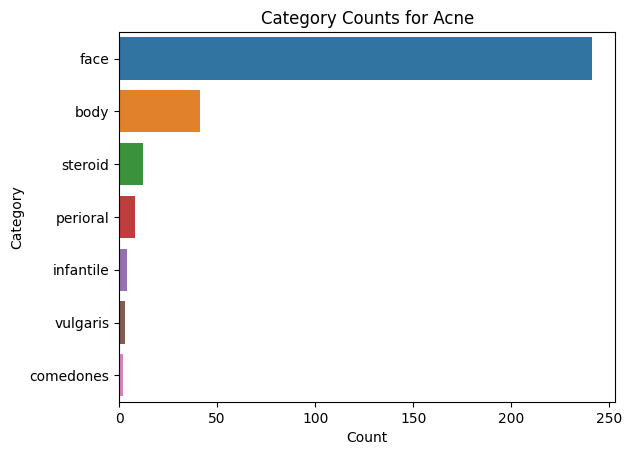

In [ ]:
# Countplot for acne categories
category_count(acne_mask, 'Category Counts for Acne')

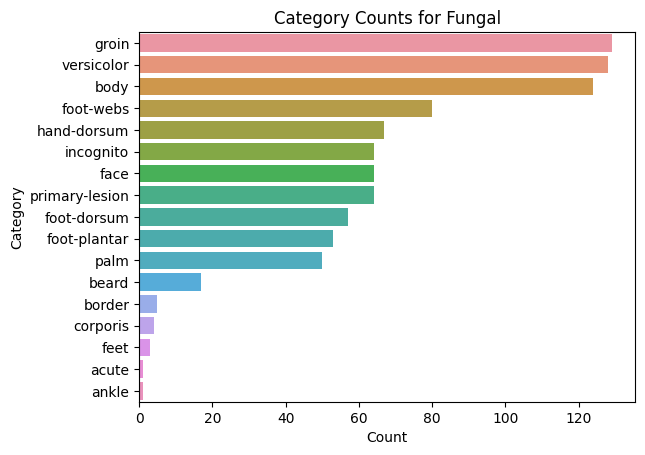

In [ ]:
# Countplot for fungal categories
category_count(fungal_mask, 'Category Counts for Fungal')

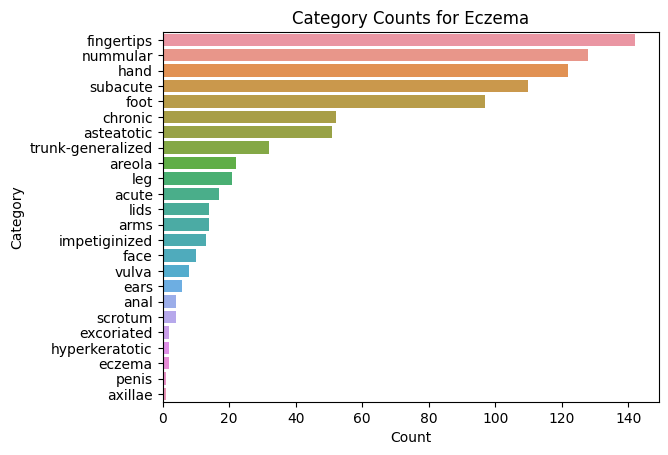

In [ ]:
# Countplot for eczema categories
category_count(eczema_mask, 'Category Counts for Eczema')

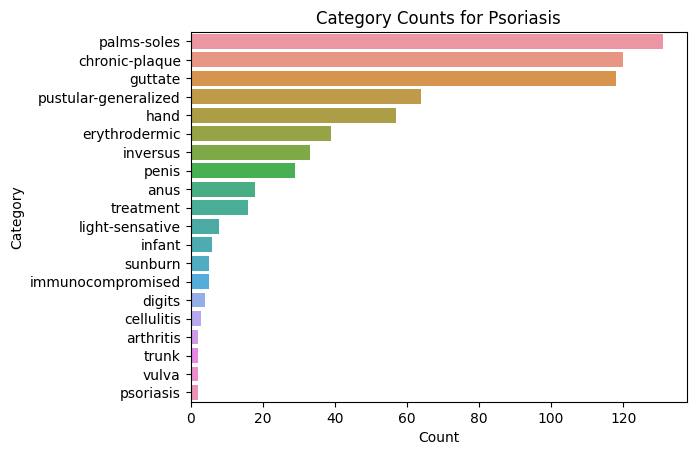

In [ ]:
# Countplot for psoriasis categories
category_count(psoriasis_mask, 'Category Counts for Psoriasis')

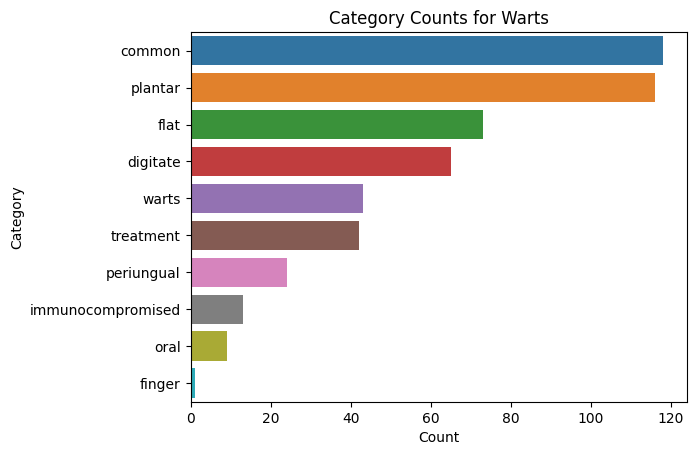

In [ ]:
# Countplot for warts categories
category_count(warts_mask, 'Category Counts for Warts')